In [18]:
import pandas as pd
import mido
import ast
import matplotlib.pyplot as plt
import numpy as np
import scipy


from sklearn.metrics.pairwise import cosine_similarity

Main file

In [21]:
#IMPORTANT FUNCTIONS

#---------------------PREPARING MIDI OF EXAMPLE MELODIES-----------------------------

"""Load the MIDI file with the stuff recorded in ableton (aka the correct target notes)
target_midi: an imported midi file. Can use mido.MidiFile('file.mid')
returns a list of lists with 4 elements each. Each of the 4-item lists represents a melody

example:
testfile = mido.MidiFile('midi_target/easy_pt1.mid')
test = midi_target(testfile)
"""

def midi_target(midi_file, chunksize=4):
    target_midi = mido.MidiFile(midi_file)
    target_notes = []
    for message in target_midi.tracks[0]:
        if message.type == "note_on":
            target_notes.append(message.note)

    split_list = [target_notes[i:i + chunksize] for i in range(0, len(target_notes), chunksize)]
    return split_list

#getting all the split lists from the files
#importing the recorded midi files

cd = midi_target('../raw_training_files_wurli/cd.mid')
cde = midi_target('../raw_training_files_wurli/cde.mid')
cdef = midi_target('../raw_training_files_wurli/cdef.mid')
d_ef = midi_target('../raw_training_files_wurli/def.mid')
efg = midi_target('../raw_training_files_wurli/efg.mid')
ef = midi_target('../raw_training_files_wurli/ef.mid')
fg = midi_target('../raw_training_files_wurli/fg.mid')
cdefg = midi_target('../raw_training_files_wurli/cdefg.mid')

#append the files in the correct presentation order to have the full set 

#-------------------------------PREPARING DATA FOR ANALYSIS-----------------------------
"""
categorizes the example melodies according to their type (i.e. which notes were in the melody)
"""
def categorize_list(lst):
    x = len(set(lst))
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x == 4: 
        return 4
    else:
        return None


"""
calculate cosine similarity between the target and the note

cos_reshape: 
makes a vector's shape compatible with the cosine similarity function from sklearn
(it also pads the list if it's shorter than 4 elements)
vec: a 1d vector

calc_cosim:
calculates cosine similarity between 2 lists after reformatting
list1, list2: the notes_vector and target vector

for later: make result scaled to make it less close to .99 all the time?
"""
def cos_reshape(vec):
    while len(vec) < 4: 
        vec.append(0)
    return np.array(vec).reshape(1, -1)

def calc_cosim(list1, list2):
    a = cos_reshape(list1)
    b = cos_reshape(list2)
    cosim = cosine_similarity(a,b)[0][0] #strips the array brackets

    #remove outliers
    if cosim < 0.995:
        cosim = None
    return cosim

"""Calculate score
This calculates a score on the participant response based on the following criteria:
1. For each index of the list where the note at that index matches the correct note, I give it one point
2. For each note that is wrong, I give a partial point. The amount of points awarded depends on the difference between 
the note that is played and the correct note. For example, playing midi note 69 awards more points than note 72 if the
 correct note was 65

 correct notes: target MIDI vector
 played_notes: notes_vector
"""
def pad_vec(vec):
    while len(vec)<4:
        vec.append(0)
    return np.array(vec)

def calc_score(correct_notes, played_notes):
    correct_array = pad_vec(correct_notes)
    played_array = pad_vec(played_notes)

    exact_matches = np.sum(correct_array == played_array) #notes that were correct and in the correct position
    differences = np.abs(correct_array - played_array) #notes that were wrong: how far off are they?

    partial_scores = [1 - 0.1 * x if x != 0 else 0 for x in differences]

    total_score = exact_matches + np.sum(partial_scores)
    
    return total_score

""" 
Setting up a dataframe with participant data 
file: the csv file with the participant responses
exampleset: the list of MIDI melodies corresponding to the correct melodies

example:
result_file = 'cindy_test2.csv' <-- one file for each participant
fullset = cd+cde <-- define the melodies used in the psychopy test
results = resp_pd(result_file, fullset)
"""
def resp_pd(file, exampleset):
    #load user responses
    #make sure that the length of target column is same as length of results
    results = pd.read_csv(file)

    #participant responses are lists embedded in strings so we have to change it back to a list
    results['notes_vector'] = [ast.literal_eval(x) for x in results['notes_vector']] 

    #adding the target column with the MIDI of the example melodies
    results['target'] = exampleset

    #calculating whether each individual response is perfect
    results['correct'] = results.apply(lambda row: 1 if row['notes_vector'] == row['target'] else 0, axis=1)

    #cosine similarity - actually not a great measure becasue many dissimmilar melodies have high scores
    #results['cosim'] = results.apply(lambda row: calc_cosim(row['target'][0:4], row['notes_vector'][0:4]), axis=1) #taking the first 4 notes of the participant response if longer

    #calculate scores based on manually defined criteria
    results['score'] = results.apply(lambda row: calc_score(row['target'][0:4], row['notes_vector'][0:4]), axis = 1 )

    #add the block number
    rows_per_block = 82 #might be changed in the future
    results['block'] = np.repeat(np.arange(1, len(results) // rows_per_block + 1), rows_per_block)

    #add the block index (ie how difficult one part of the block is; cd vs cde vs cdefg and so on...)
    results['type'] = results['target'].apply(categorize_list)

    return results

In [3]:
#PARAMETERS

#define the number of cycles in the training
numcycles = 5
#define the list of targets
fullset = cd+cde+d_ef+ef+fg+efg+cdef+cdefg
fullset = fullset*numcycles

In [4]:
#SUBJECT INFO

#define which files are being used
subject_file = 'train_responses_matthew.csv'

#preparing a dataframe for the subject
subj_res = resp_pd(subject_file, fullset)

subj_res[0:20]

,trial_number,notes_vector,target,correct,cosim,score,block,type
0,1,"[71, 67, 69, 65, 72]","[72, 72, 72, 72]",0,0.999460,2.4,1,1
1,2,"[72, 72, 72, 72, 71, 72]","[72, 72, 71, 72]",0,0.999982,3.9,1,2
2,3,"[69, 72, 72, 71, 67, 69]","[72, 71, 71, 71]",0,0.999734,3.5,1,2
3,4,"[69, 69, 65, 72, 72, 71, 72]","[71, 72, 71, 72]",0,0.999500,2.9,1,2
4,5,"[72, 72, 71, 69, 69]","[72, 71, 71, 72]",0,0.999778,3.6,1,2
5,6,"[72, 72, 71, 71]","[71, 71, 72, 72]",0,0.999902,3.6,1,2
6,7,"[72, 71, 69, 69]","[72, 71, 69, 69]",1,1.000000,4.0,1,3
7,8,"[69, 71, 72, 71, 71, 71]","[72, 69, 72, 72]",0,0.999678,3.4,1,2
8,9,"[72, 71, 69, 67, 69]","[72, 71, 69, 72]",0,0.999523,3.5,1,3
9,10,"[72, 72, 69, 69]","[69, 69, 71, 71]",0,0.999368,3.0,1,2


Possible analyses

In [5]:
print('first 20', subj_res['score'][0:20].mean())
print('last 20', subj_res['score'][-20:].mean())

first 20 2.925
last 20 3.7350000000000003


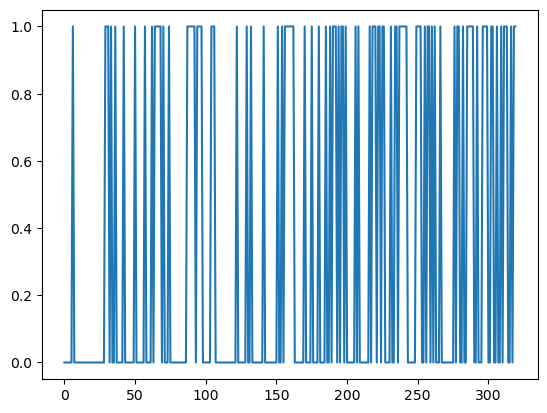

In [6]:
#raw correctness
plt.plot(subj_res['correct'])

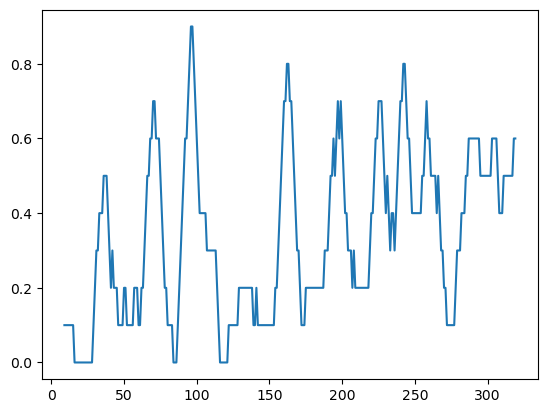

In [7]:
#rolling average on whether the melody is correct
smoothness = 10

rolling_corr = subj_res['correct'].rolling(smoothness).mean()
plt.plot(rolling_corr)

Text(0, 0.5, 'Rolling average score over 10 trials')

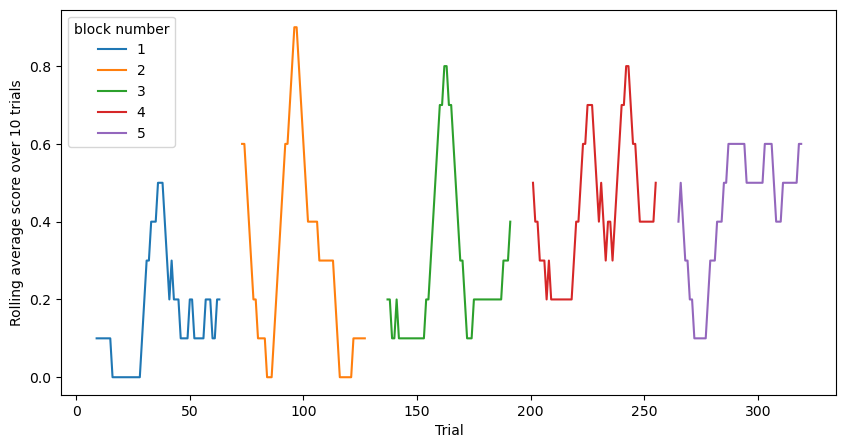

In [8]:
#rolling ave over trials
smoothness = 10

plt.figure(figsize=(10,5))
for i in range(numcycles):
    rolling_corr = subj_res[subj_res['block']==i+1]['correct'].rolling(smoothness).mean()
    plt.plot(rolling_corr, label = i+1)


plt.xlabel("Trial")
plt.legend(title = 'block number')
plt.ylabel("Rolling average score over 10 trials")
   

Text(0, 0.5, 'Average score')

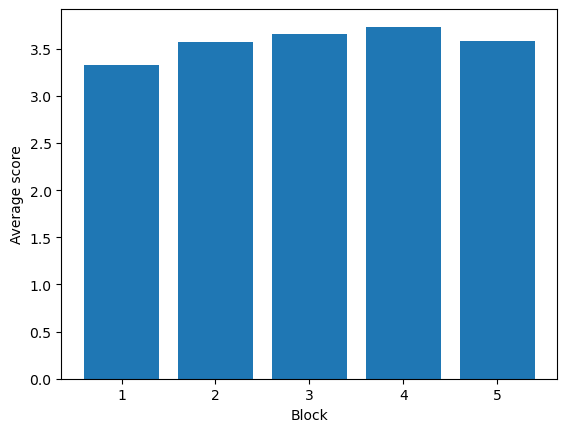

In [9]:
#perfect response over blocks
mean_blocks = []
for block in range(1,6):
    score = np.mean(subj_res[subj_res['block']==block]['score'])
    mean_blocks.append(score)

plt.bar(np.arange(1, 6, 1), mean_blocks)
plt.xlabel('Block')
plt.ylabel('Average score')

Text(0, 0.5, 'Perfect response rate')

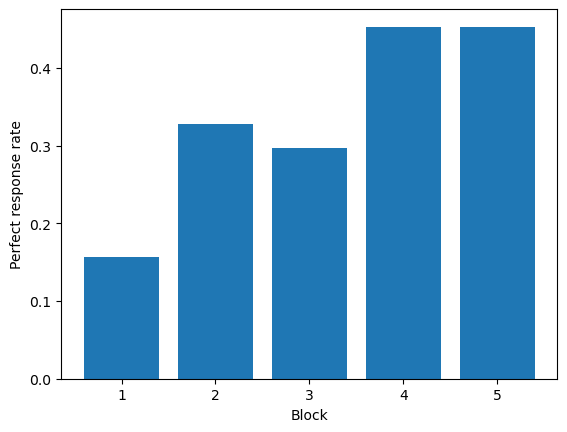

In [10]:
#perfect response over blocks
mean_blocks = []
for block in range(1,6):
    score = np.mean(subj_res[subj_res['block']==block]['correct'])
    mean_blocks.append(score)

plt.bar(np.arange(1, 6, 1), mean_blocks)
plt.xlabel('Block')
plt.ylabel('Perfect response rate')

([<matplotlib.axis.XTick at 0x177336980>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

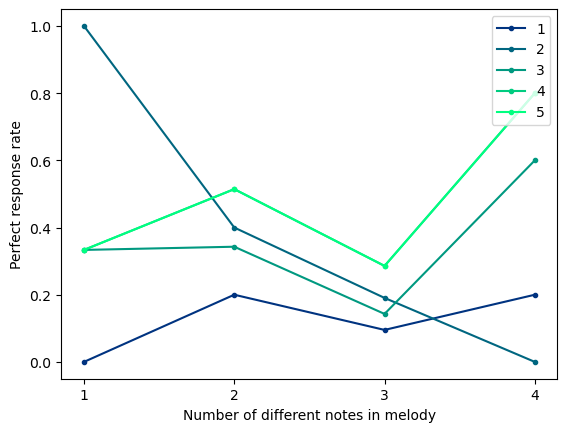

In [11]:
#scores sorted by difficulty
for block in range(1, 6):
    res_temp = subj_res[subj_res['block']==block]

    diff_score = []
    for i in range(1,5):
        diff = res_temp[res_temp['type'] == i]
        diff_score.append(np.mean(diff['correct']))
        #score = np.mean(diff['correct'])
        #plt.scatter(i, score, c = (0.5, 0.5, float(block)/5), cmap='blues')
    plt.plot(np.arange(1, 5, 1), diff_score, c = (0, float(block)/5, 0.5), marker = '.', label = block)

plt.legend(loc = 'upper right')
plt.ylabel('Perfect response rate')
plt.xlabel('Number of different notes in melody')
plt.xticks(np.arange(1, 5, 1))

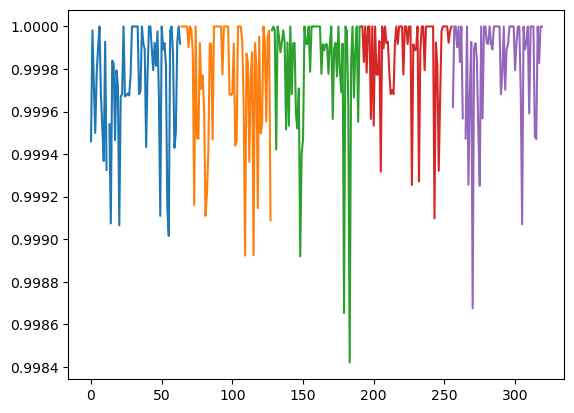

In [12]:
#cosine similarity
for i in range(numcycles):
    plt.plot(subj_res[subj_res['block']== i+1]['cosim'])

([<matplotlib.axis.XTick at 0x177456170>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

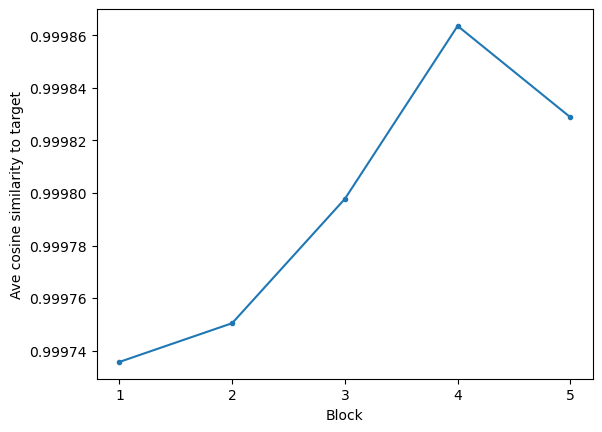

In [13]:
cosim_aves = [] 
for i in range(numcycles):
    mean_sim = np.mean(subj_res[subj_res['block']== i+1]['cosim'])
    cosim_aves.append(mean_sim) 

plt.plot(np.arange(1, numcycles+1), cosim_aves, marker = '.')
plt.ylabel('Ave cosine similarity to target')
plt.xlabel('Block')
plt.xticks(np.arange(1, numcycles+1, 1))

In [14]:
subj_res

,trial_number,notes_vector,target,correct,cosim,score,block,type
0,1,"[71, 67, 69, 65, 72]","[72, 72, 72, 72]",0,0.999460,2.4,1,1
1,2,"[72, 72, 72, 72, 71, 72]","[72, 72, 71, 72]",0,0.999982,3.9,1,2
2,3,"[69, 72, 72, 71, 67, 69]","[72, 71, 71, 71]",0,0.999734,3.5,1,2
3,4,"[69, 69, 65, 72, 72, 71, 72]","[71, 72, 71, 72]",0,0.999500,2.9,1,2
4,5,"[72, 72, 71, 69, 69]","[72, 71, 71, 72]",0,0.999778,3.6,1,2
...,...,...,...,...,...,...,...,...
315,316,"[65, 71, 65, 67]","[65, 67, 65, 69]",0,0.999470,3.4,5,3
316,317,"[65, 65, 72, 72]","[65, 65, 72, 72]",1,1.000000,4.0,5,2
317,318,"[65, 72, 72, 72]","[65, 69, 72, 72]",0,0.999828,3.7,5,3
318,319,"[65, 65, 65, 72]","[65, 65, 65, 72]",1,1.000000,4.0,5,2


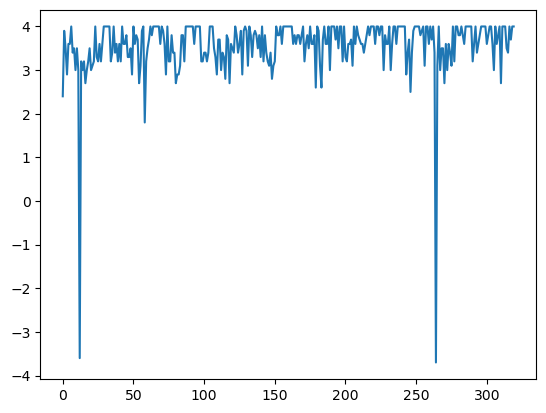

In [15]:
plt.plot(subj_res['score'])

3.3296875000000004
3.5734375
3.6515625000000003
3.7328124999999996
3.5796875


([<matplotlib.axis.XTick at 0x177552410>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

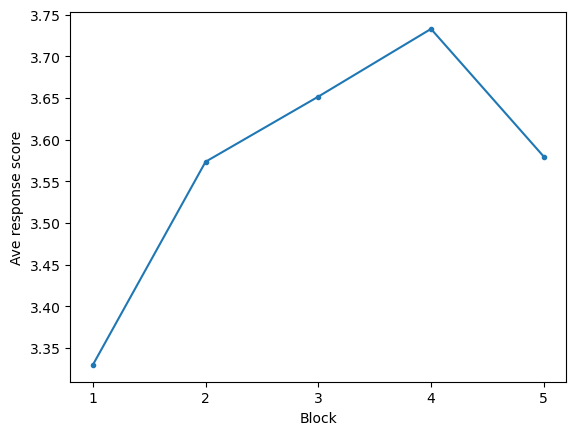

In [16]:
scores = [] 
for i in range(numcycles):
    mean_score = np.mean(subj_res[subj_res['block']== i+1]['score'])
    scores.append(mean_score) 
    print(mean_score)

plt.plot(np.arange(1, numcycles+1), scores, marker = '.')
plt.ylabel('Ave response score')
plt.xlabel('Block')
plt.xticks(np.arange(1, numcycles+1, 1))

Stats

In [17]:
from scipy.stats import ttest_rel
rvs1 = [1,1,2,1]
rvs2 = [4,2,3,4]
ttest_rel(rvs1, rvs2)

TtestResult(statistic=-3.464101615137755, pvalue=0.040519326353833984, df=3)